In [1]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import text
from io import StringIO
import csv
import pathlib
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.express as px
import time, psutil, contextlib, os

# ── CONFIG ────────────────────────────────────────────────────────────────────
DATA_DIR = pathlib.Path("/Users/swarnaditya_maitra/anaconda_projects/Self-Learning/SQL/MSDSP_420_FinalProject")
USER     = "postgres"
PASSWORD = "root"
HOST     = "127.0.0.1"
PORT     = "5432"
DBNAME   = "complete_journey"
CHUNK    = 50_000                                 

# ── CONNECT ───────────────────────────────────────────────────────────────────
engine = sa.create_engine(
    f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}"
)

sns.set_theme(style="whitegrid")

def q(sql: str, **params) -> pd.DataFrame:
    """Quick SQL → pandas."""
    return pd.read_sql_query(text(sql), engine, params=params)

@contextlib.contextmanager
def timer(label=""):
    t0 = time.perf_counter()
    yield
    t1 = time.perf_counter()
    print(f"{label:<55} {t1-t0:8.3f} s")

def mem_mb():   # current RSS in MB
    return psutil.Process(os.getpid()).memory_info().rss / 1024**2

print(f"Python RSS at start: {mem_mb():.1f} MB")

Python RSS at start: 240.8 MB


In [2]:
file_map = {
    "hh_demographic":   "hh_demographic.csv",
    "product":          "product.csv",
    "campaign_desc":    "campaign_desc.csv",
    "campaign_table":   "campaign_table.csv",
    "coupon":           "coupon.csv",
    "coupon_redempt":   "coupon_redempt.csv",
    "transaction_data": "transaction_data.csv",
    "causal_data":      "causal_data.csv",
}

# ── load every CSV into memory  ───────────────────────────────────────
orig = {}
for tbl, fname in file_map.items():
    path = DATA_DIR / fname
    df = pd.read_csv(path, low_memory=False)
    print(f"read {fname:25s} → {len(df):,} rows")     # <─ new line
    df.columns = df.columns.str.lower()

    if tbl == "hh_demographic":
        df.rename(
            columns={
                "classification_1": "age_desc",
                "classification_2": "marital_status_code",
                "classification_3": "income_desc",
                "classification_5": "hh_comp_desc",
                "classification_4": "household_size_desc"
            },
            inplace=True,
        )
    orig[tbl] = df

# ── derive valid household list ───────────────────────────────────────────
valid_hh = set(orig["hh_demographic"]["household_key"])
print(f"\ndemographic table contains {len(valid_hh):,} households\n")

# ── clean the three referencing tables ────────────────────────────────────
clean = {}
print("Data-cleaning for bad foreign key references to hh_demographic")
print(f"{'table':<20} | {'before':>12} | {'after':>12} | {'dropped':>12}")
print("-" * 65)

for tbl in ["campaign_table", "transaction_data", "coupon_redempt"]:
    df = orig[tbl]
    before = len(df)
    df_clean = df[df["household_key"].isin(valid_hh)].copy()
    after = len(df_clean)
    dropped = before - len(df_clean)
    print(f"{tbl:<20} | {before:>12} | {len(df_clean):>12,} | {dropped:>12,}")
    clean[tbl] = df_clean


# Tables that do not reference household_key
for tbl in ["product", "campaign_desc", "coupon", "causal_data"]:
    clean[tbl] = orig[tbl]

# hh_demographic itself
clean["hh_demographic"] = orig["hh_demographic"]

# Helper: PK columns per table  (used for drop_duplicates)
pk_cols = {
    "hh_demographic":   ["household_key"],
    "product":          ["product_id"],
    "campaign_desc":    ["campaign"],
    "campaign_table":   ["household_key", "campaign"],
    "coupon":           ["campaign", "coupon_upc", "product_id"],
    "coupon_redempt":   ["household_key", "day", "coupon_upc", "campaign"],
    "transaction_data": ["household_key", "basket_id", "product_id"],
    "causal_data":      ["product_id", "store_id", "week_no", "display", "mailer"],
}

# de-duplicate & report
print("\nData-cleaning for duplicate records")
print(f"{'table':<20} | {'before':>12} | {'after':>12} | {'dropped':>12}")
print("-" * 65)

for tbl in file_map:                       
    df = clean[tbl]
    before = len(df)
    df = df.drop_duplicates(subset=pk_cols[tbl])
    after = len(df)
    removed = before - after
    clean[tbl] = df                        
    print(f"{tbl:<20} | {before:>12,} | {after:>12,} | {removed:>12,}")

read hh_demographic.csv        → 801 rows
read product.csv               → 92,353 rows
read campaign_desc.csv         → 30 rows
read campaign_table.csv        → 7,208 rows
read coupon.csv                → 124,548 rows
read coupon_redempt.csv        → 2,318 rows
read transaction_data.csv      → 2,595,732 rows
read causal_data.csv           → 36,786,524 rows

demographic table contains 801 households

Data-cleaning for bad foreign key references to hh_demographic
table                |       before |        after |      dropped
-----------------------------------------------------------------
campaign_table       |         7208 |        4,213 |        2,995
transaction_data     |      2595732 |    1,427,303 |    1,168,429
coupon_redempt       |         2318 |        1,856 |          462

Data-cleaning for duplicate records
table                |       before |        after |      dropped
-----------------------------------------------------------------
hh_demographic       |          801

In [3]:
# normalise_and_generate_ddl  ────────────────────────────────────────────
from collections import OrderedDict

norm = OrderedDict()          # final 3-NF DataFrames
ddl  = []                     

# ───────────────── PRODUCT hierarchy - 3 lookup tables ────────────────────────
product = clean["product"]

# department
dept = (product[["department"]].drop_duplicates()
        .reset_index(drop=True)
        .assign(department_id=lambda d: d.index+1))
norm["department"] = dept
ddl.append("""
CREATE TABLE IF NOT EXISTS department (
    department_id INT PRIMARY KEY,
    department    TEXT UNIQUE
);""")

# commodity
commodity = (product[["department", "commodity_desc"]].drop_duplicates()
             .merge(dept, on="department")
             .reset_index(drop=True)
             .assign(commodity_id=lambda d: d.index+1))
norm["commodity"] = commodity[["commodity_id","department_id","commodity_desc"]]
ddl.append("""
CREATE TABLE IF NOT EXISTS commodity (
    commodity_id   INT PRIMARY KEY,
    department_id  INT REFERENCES department(department_id),
    commodity_desc TEXT
);""")

# sub-commodity
subcomm = (
    product[["department","commodity_desc","sub_commodity_desc"]]
    .drop_duplicates()
    .merge(commodity, on=["department","commodity_desc"])
    .reset_index(drop=True)
    .assign(sub_commodity_id=lambda d: d.index+1)
)
norm["sub_commodity"] = subcomm[
    ["sub_commodity_id","commodity_id","sub_commodity_desc"]
]
ddl.append("""
CREATE TABLE IF NOT EXISTS sub_commodity (
    sub_commodity_id  INT PRIMARY KEY,
    commodity_id      INT REFERENCES commodity(commodity_id),
    sub_commodity_desc TEXT
);""")

# slim product
norm["product"] = (
    product.merge(subcomm, on=["department","commodity_desc","sub_commodity_desc"])
           .drop(columns=["department","commodity_desc","sub_commodity_desc"])
           [["product_id","manufacturer","brand","curr_size_of_product",
             "sub_commodity_id"]]
)
ddl.append("""
CREATE TABLE IF NOT EXISTS product (
    product_id INT PRIMARY KEY,
    manufacturer INT,
    brand TEXT,
    curr_size_of_product TEXT,
    sub_commodity_id INT REFERENCES sub_commodity(sub_commodity_id)
);""")

# ───────────────── COUPON - header / item ──────────────────────────────────
coupon = clean["coupon"]
norm["coupon_header"] = (
    coupon[["campaign","coupon_upc"]].drop_duplicates().reset_index(drop=True)
)
norm["coupon_item"]   = coupon[["campaign","coupon_upc","product_id"]]

ddl.extend([
"""
CREATE TABLE IF NOT EXISTS coupon_header (
    campaign   INT,
    coupon_upc BIGINT,
    PRIMARY KEY (campaign, coupon_upc)
);""",
"""
CREATE TABLE IF NOT EXISTS coupon_item (
    campaign   INT,
    coupon_upc BIGINT,
    product_id INT,
    PRIMARY KEY (campaign, coupon_upc, product_id),
    FOREIGN KEY (campaign, coupon_upc)
        REFERENCES coupon_header(campaign, coupon_upc),
    FOREIGN KEY (product_id) REFERENCES product(product_id)
);"""])

# ───────────────── TRANSACTION_DATA - basket_header / item ─────────────────
tx = clean["transaction_data"]
norm["basket_header"] = (
    tx[["basket_id","household_key","day","week_no","store_id","trans_time"]]
    .drop_duplicates()
)
norm["basket_item"] = tx.drop(columns=["day","week_no","store_id","trans_time","household_key"])

ddl.extend([
"""
CREATE TABLE IF NOT EXISTS basket_header (
    basket_id     BIGINT PRIMARY KEY,
    household_key INT,
    day INT,
    week_no INT,
    store_id INT,
    trans_time INT,
    FOREIGN KEY (household_key)
        REFERENCES hh_demographic(household_key)
);""",
"""
CREATE TABLE IF NOT EXISTS basket_item (
    basket_id        BIGINT,
    product_id       INT,
    quantity         INT,
    sales_value      NUMERIC(8,2),
    retail_disc      NUMERIC(8,2),
    coupon_disc      NUMERIC(8,2),
    coupon_match_disc NUMERIC(8,2),
    PRIMARY KEY (basket_id, product_id),
    FOREIGN KEY (basket_id)  REFERENCES basket_header(basket_id),
    FOREIGN KEY (product_id) REFERENCES product(product_id)
);"""])

# ───────────────── Tables already 3-NF  ────────────────────────
for t in ["hh_demographic","campaign_desc","campaign_table",
          "coupon_redempt","causal_data"]:
    norm[t] = clean[t].copy()

ddl.extend([
"""
CREATE TABLE IF NOT EXISTS hh_demographic (
    household_key INT PRIMARY KEY,
    age_desc TEXT,
    marital_status_code CHAR(1),
    income_desc TEXT,
    homeowner_desc TEXT,
    hh_comp_desc TEXT,
    household_size_desc TEXT,
    kid_category_desc TEXT
);""",
"""
CREATE TABLE IF NOT EXISTS campaign_desc (
    campaign INT PRIMARY KEY,
    description TEXT,
    start_day INT,
    end_day INT
);""",
"""
CREATE TABLE IF NOT EXISTS campaign_table (
    description TEXT,
    household_key INT,
    campaign INT,
    PRIMARY KEY (household_key, campaign),
    FOREIGN KEY (household_key) REFERENCES hh_demographic(household_key),
    FOREIGN KEY (campaign)      REFERENCES campaign_desc(campaign)
);""",
"""
CREATE TABLE IF NOT EXISTS coupon_redempt (
    household_key INT,
    day INT,
    coupon_upc BIGINT,
    campaign INT,
    PRIMARY KEY (household_key, day, coupon_upc, campaign),
    FOREIGN KEY (campaign, coupon_upc)
        REFERENCES coupon_header(campaign, coupon_upc)
);""",
"""
CREATE TABLE IF NOT EXISTS causal_data (
    product_id INT,
    store_id INT,
    week_no INT,
    display CHAR(1),
    mailer  CHAR(1),
    PRIMARY KEY (product_id, store_id, week_no, display, mailer),
    FOREIGN KEY (product_id) REFERENCES product(product_id)
);"""
])

# ── rea-assigning the primary-key map for every 3-NF table we generated ─────────────────────

# Primary-key maps
orig_pk_cols = {
    "hh_demographic" : ["household_key"],
    "product"        : ["product_id"],
    "campaign_desc"  : ["campaign"],
    "campaign_table" : ["household_key", "campaign"],
    "coupon"         : ["campaign", "coupon_upc", "product_id"],
    "coupon_redempt" : ["household_key", "day", "coupon_upc", "campaign"],
    "transaction_data": ["household_key", "basket_id", "product_id"],
    "causal_data"    : ["product_id", "store_id", "week_no", "display", "mailer"],
}

orig_nf_status = {
    "hh_demographic" : "3 NF",
    "product"        : "2 NF",
    "campaign_desc"  : "3 NF",
    "campaign_table" : "BCNF",
    "coupon"         : "2 NF",
    "coupon_redempt" : "3 NF",
    "transaction_data": "1 NF",
    "causal_data"    : "3 NF",
}

new_pk_cols = {
    "department"     : ["department_id"],
    "commodity"      : ["commodity_id"],
    "sub_commodity"  : ["sub_commodity_id"],
    "product"        : ["product_id"],
    "hh_demographic" : ["household_key"],
    "campaign_desc"  : ["campaign"],
    "campaign_table" : ["household_key", "campaign"],
    "coupon_header"  : ["campaign", "coupon_upc"],
    "coupon_item"    : ["campaign", "coupon_upc", "product_id"],
    "coupon_redempt" : ["household_key", "day", "coupon_upc", "campaign"],
    "basket_header"  : ["basket_id"],
    "basket_item"    : ["basket_id", "product_id"],
    "causal_data"    : ["product_id", "store_id", "week_no", "display", "mailer"],
}

new_nf_status = {
    "department"     : "BCNF",
    "commodity"      : "BCNF",
    "sub_commodity"  : "BCNF",
    "product"        : "BCNF",
    "hh_demographic" : "3 NF",
    "campaign_desc"  : "BCNF",
    "campaign_table" : "BCNF",
    "coupon_header"  : "BCNF",
    "coupon_item"    : "BCNF",
    "coupon_redempt" : "BCNF",
    "basket_header"  : "BCNF",
    "basket_item"    : "BCNF",
    "causal_data"    : "BCNF",
}

# Pretty-print helpers
def print_summary(title: str, frames: dict, pk_dict: dict, nf_dict: dict):
    print(f"\n{title}")
    print(f"{'table':<17} | {'primary key columns':<46} | {'rows':>10} | {'NF':^4}")
    print("-" * 92)
    for tbl in pk_dict:
        rows = len(frames[tbl])
        pk   = ", ".join(pk_dict[tbl])
        nf   = nf_dict[tbl]
        print(f"{tbl:<17} | {pk:<46} | {rows:>10,} | {nf:^4}")

print_summary("BEFORE normalising (clean DataFrames)", clean, orig_pk_cols, orig_nf_status)
print_summary("\nAFTER normalising (3-NF / BCNF)",      norm,  new_pk_cols,  new_nf_status)


BEFORE normalising (clean DataFrames)
table             | primary key columns                            |       rows |  NF 
--------------------------------------------------------------------------------------------
hh_demographic    | household_key                                  |        801 | 3 NF
product           | product_id                                     |     92,353 | 2 NF
campaign_desc     | campaign                                       |         30 | 3 NF
campaign_table    | household_key, campaign                        |      4,213 | BCNF
coupon            | campaign, coupon_upc, product_id               |    119,384 | 2 NF
coupon_redempt    | household_key, day, coupon_upc, campaign       |      1,856 | 3 NF
transaction_data  | household_key, basket_id, product_id           |  1,427,303 | 1 NF
causal_data       | product_id, store_id, week_no, display, mailer | 36,786,524 | 3 NF


AFTER normalising (3-NF / BCNF)
table             | primary key columns            

In [4]:
# Insert into database
pat = re.compile(r"CREATE\s+TABLE(?:\s+IF\s+NOT\s+EXISTS)?\s+(\w+)", re.I)
ddl_lookup = {pat.search(stmt).group(1).lower(): stmt for stmt in ddl}

# FK-safe sequence
table_sequence = [
    # product hierarchy
    "department",
    "commodity",
    "sub_commodity",
    "product",

    # household dimension
    "hh_demographic",

    # campaigns
    "campaign_desc",
    "campaign_table",

    # coupons
    "coupon_header",
    "coupon_item",
    "coupon_redempt",

    # baskets / transactions
    "basket_header",
    "basket_item",

    # promotional causal
    "causal_data",
]

ddl_ordered = [ddl_lookup[t] for t in table_sequence if t in ddl_lookup]

# execute
with engine.begin() as conn:         
    for stmt in ddl_ordered:
        conn.execute(text(stmt))

print("All tables created in parent-before-child order.")

All tables created in parent-before-child order.


In [5]:
def psql_insert_copy(table, conn, keys, data_iter):
    """
    Speedy bulk-loader: pandas → COPY … FROM STDIN
    """
    buf = StringIO()
    csv.writer(buf).writerows(data_iter)
    buf.seek(0)

    cols = ", ".join(f'"{k}"' for k in keys)
    tbl  = f'{table.schema + "." if table.schema else ""}{table.name}'
    sql  = f"COPY {tbl} ({cols}) FROM STDIN WITH CSV"

    dbapi_conn = conn.connection       
    with dbapi_conn.cursor() as cur:
        cur.copy_expert(sql, buf)

load_order = table_sequence

# Truncate everything we’re about to reload 
with engine.begin() as conn:
    conn.execute(text("""
        TRUNCATE
            causal_data,
            basket_item,
            basket_header,
            coupon_redempt,
            coupon_item,
            coupon_header,
            campaign_table,
            campaign_desc,
            product,
            sub_commodity,
            commodity,
            department,
            hh_demographic
        RESTART IDENTITY CASCADE;
    """))

# Bulk-insert each DataFrame
for tbl in load_order:
    df = norm[tbl]                    
    print(f"loading {tbl:<15} … ", end="", flush=True)

    inserted = 0
    for start in range(0, len(df), CHUNK):
        chunk = df.iloc[start : start + CHUNK]
        chunk.to_sql(
            name       = tbl,
            con        = engine,
            if_exists  = "append",
            index      = False,
            method     = psql_insert_copy,
        )
        inserted += len(chunk)

    print(f"{inserted:,} rows inserted")

loading department      … 44 rows inserted
loading commodity       … 360 rows inserted
loading sub_commodity   … 3,912 rows inserted
loading product         … 92,353 rows inserted
loading hh_demographic  … 801 rows inserted
loading campaign_desc   … 30 rows inserted
loading campaign_table  … 4,213 rows inserted
loading coupon_header   … 1,397 rows inserted
loading coupon_item     … 119,384 rows inserted
loading coupon_redempt  … 1,856 rows inserted
loading basket_header   … 140,339 rows inserted
loading basket_item     … 1,427,303 rows inserted
loading causal_data     … 36,786,524 rows inserted


In [6]:
# 1 - Central-tendency & spread on key numeric fields
with timer("basket-level spend distribution"):
    basket_stat = q(f"""
        SELECT
            SUM(bi.sales_value) AS basket_sales,
            COUNT(*)            AS lines
        FROM   basket_item bi
        GROUP  BY bi.basket_id
    """)
basket_stat.describe(percentiles=[.25,.5,.75,.9,.95])

basket-level spend distribution                            0.530 s


,basket_sales,lines
count,140339.000000,140339.000000
mean,32.048940,10.170395
std,38.308015,13.108400
min,0.000000,1.000000
25%,7.950000,2.000000
50%,19.750000,5.000000
75%,40.210000,13.000000
90%,77.852000,27.000000
95%,110.091000,38.000000
max,961.490000,168.000000


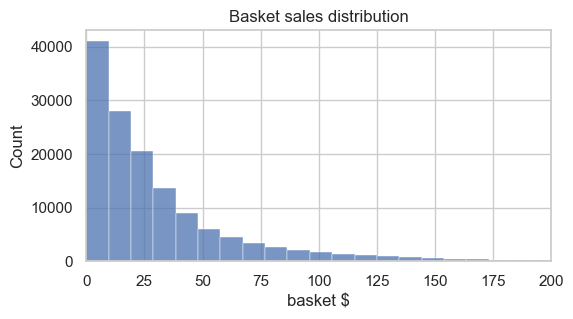

household annual spend stats                               0.160 s


year,1,2,delta
count,801.000000,801.000000,801.000000
mean,2469.194569,3145.931848,676.737278
std,1841.543652,2135.734588,1354.898361
min,7.070000,124.240000,-5059.280000
25%,1183.220000,1670.010000,-78.690000
50%,1981.100000,2585.510000,602.070000
75%,3254.560000,4067.420000,1300.520000
max,13323.450000,14536.230000,9690.950000


In [7]:
# histogram of basket size ($)
plt.figure(figsize=(6,3))
sns.histplot(basket_stat["basket_sales"], bins=100, kde=False)
plt.xlim(0, 200)
plt.title("Basket sales distribution"); plt.xlabel("basket $"); plt.show()

with timer("household annual spend stats"):
    spend_year = q(f"""
        SELECT bh.household_key,
               CASE WHEN bh.day <= 364 THEN 1 ELSE 2 END AS year,
               SUM(bi.sales_value) AS sales
        FROM   basket_header bh
        JOIN   basket_item  bi USING(basket_id)
        GROUP  BY bh.household_key, year
    """)
pivot = spend_year.pivot(index="household_key", columns="year", values="sales").fillna(0)
pivot["delta"] = pivot[2] - pivot[1]
pivot.describe()

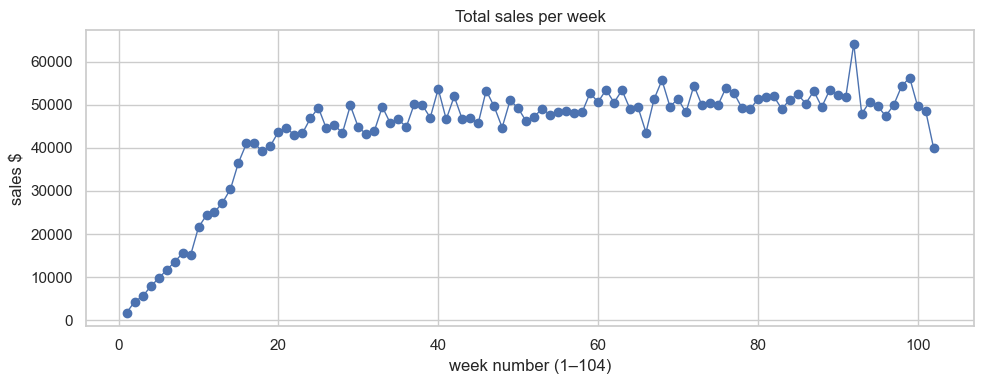

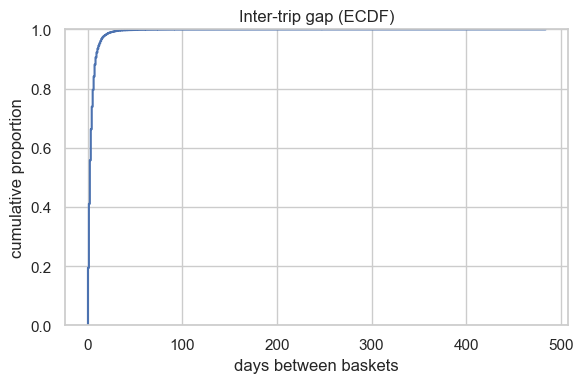

In [8]:
# 2 - total sales per week ─────────────────────────────────────────────
weekly = q(f"""
    SELECT bh.week_no, SUM(bi.sales_value) AS sales
    FROM   basket_header bh
    JOIN   basket_item  bi USING(basket_id)
    GROUP  BY bh.week_no
    ORDER  BY bh.week_no
""")

plt.figure(figsize=(10,4))
plt.plot(weekly["week_no"], weekly["sales"], marker="o", linewidth=1)
plt.title("Total sales per week")
plt.xlabel("week number (1‒104)")
plt.ylabel("sales $")
plt.tight_layout()
plt.show()

# ECDF of days-between-trips ───────────────────────────────────────
delta = q(f"""
    SELECT household_key,
           day - LAG(day) OVER (PARTITION BY household_key ORDER BY day) AS gap
    FROM   basket_header
""")

plt.figure(figsize=(6,4))
sns.ecdfplot(delta["gap"].dropna(), linewidth=1.5)
plt.xlabel("days between baskets")
plt.ylabel("cumulative proportion")
plt.title("Inter-trip gap (ECDF)")
plt.tight_layout()
plt.show()

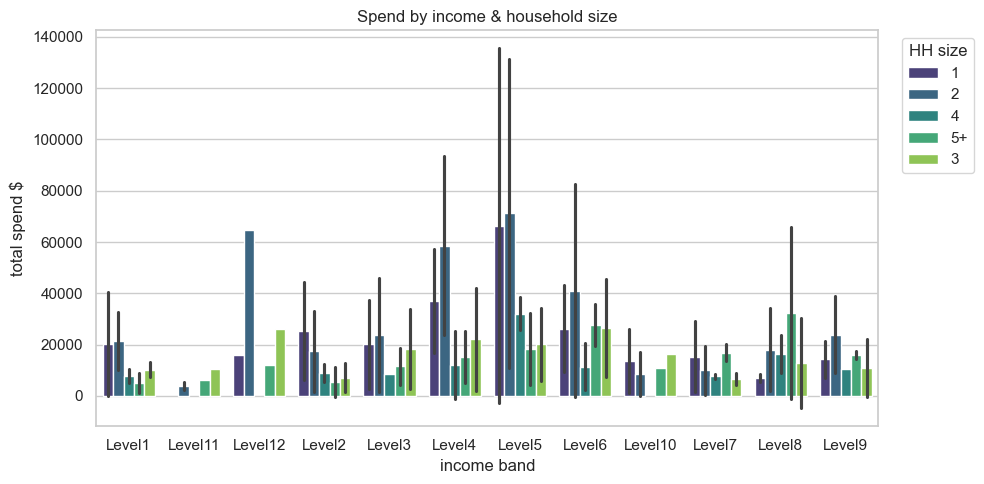

In [9]:
# 3 - Demographic influence
demo_spend = q(f"""
    SELECT d.age_desc,
           d.income_desc,
           d.household_size_desc,
           SUM(bi.sales_value) AS spend
    FROM   hh_demographic d
    JOIN   basket_header bh USING(household_key)
    JOIN   basket_item  bi USING(basket_id)
    GROUP  BY 1,2,3
""")

plt.figure(figsize=(10,5))
sns.barplot(data=demo_spend,
            x="income_desc", y="spend",
            hue="household_size_desc",
            palette="viridis", errorbar="sd")

plt.title("Spend by income & household size")
plt.xlabel("income band")
plt.ylabel("total spend $")
plt.legend(title="HH size", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

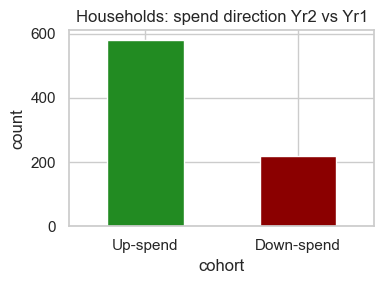

In [10]:
# 4 Up- vs down-spend cohorts
# classify households
pivot["cohort"] = np.where(pivot["delta"]>0, "Up-spend", "Down-spend")

plt.figure(figsize=(4,3))
pivot["cohort"].value_counts().plot(kind="bar", color=["forestgreen","darkred"])
plt.title("Households: spend direction Yr2 vs Yr1")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

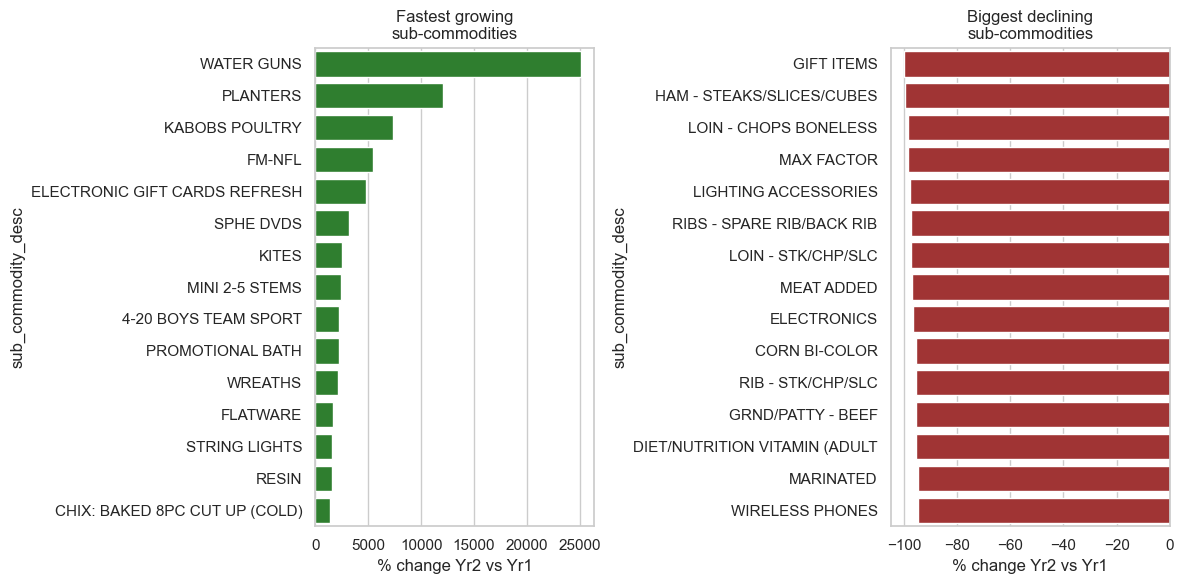

In [12]:
# 5 - Fastest growing / declining categories

# query category sales  ──────────────────────────────────────
cat_growth = q(f"""
    SELECT sc.sub_commodity_desc,
           SUM(CASE WHEN bh.day <= 364 THEN bi.sales_value END) AS yr1,
           SUM(CASE WHEN bh.day >  364 THEN bi.sales_value END) AS yr2
    FROM   basket_header bh
    JOIN   basket_item  bi USING (basket_id)
    JOIN   product      p  USING (product_id)
    JOIN   sub_commodity sc USING (sub_commodity_id)
    GROUP  BY sc.sub_commodity_desc
""")

# compute % change and pick top / bottom 15  ────────────────
cat_growth["pct_change"] = 100 * (cat_growth["yr2"] - cat_growth["yr1"]) / cat_growth["yr1"]
cat_growth.replace([np.inf, -np.inf], np.nan, inplace=True)   # guard ÷0
cat_growth.dropna(subset=["pct_change"], inplace=True)

top_grow = cat_growth.nlargest(15, "pct_change")
top_decl = cat_growth.nsmallest(15, "pct_change")

# plot  ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False)

# fastest growing
sns.barplot(ax=axes[0], data=top_grow,
            y="sub_commodity_desc", x="pct_change",
            color="forestgreen")
axes[0].set_title("Fastest growing\nsub-commodities")
axes[0].set_xlabel("% change Yr2 vs Yr1")

# biggest declining
sns.barplot(ax=axes[1], data=top_decl,
            y="sub_commodity_desc", x="pct_change",
            color="firebrick")
axes[1].set_title("Biggest declining\nsub-commodities")
axes[1].set_xlabel("% change Yr2 vs Yr1")

plt.tight_layout()
plt.show()

coupon lift                                                1.010 s


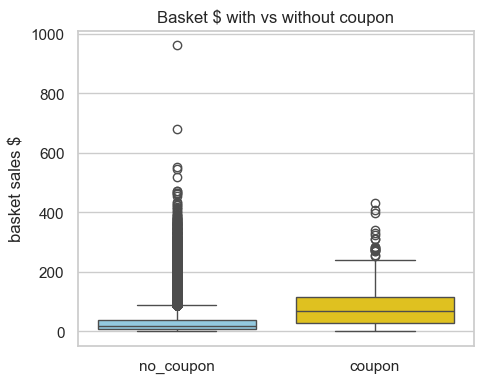

In [13]:
# 6 - Coupon lift – basket spend distribution

with timer("coupon lift"):
    lift = q(f"""
        WITH redempt_baskets AS (
            SELECT DISTINCT basket_id
            FROM   coupon_redempt cr
            JOIN   basket_header bh
              ON   cr.household_key = bh.household_key
             AND   cr.day          = bh.day
        )
        SELECT
          CASE WHEN rb.basket_id IS NOT NULL
               THEN 'coupon' ELSE 'no_coupon' END AS flag,
          bi.basket_id,
          SUM(bi.sales_value) AS basket_sales
        FROM   basket_item bi
        JOIN   basket_header bh USING (basket_id)
        LEFT JOIN redempt_baskets rb USING (basket_id)
        GROUP  BY flag, bi.basket_id
    """)

plt.figure(figsize=(5,4))
sns.boxplot(data=lift,
            x="flag",
            y="basket_sales",
            hue="flag",                # ← same column
            palette={"coupon":"gold",
                     "no_coupon":"skyblue"},
            legend=False)              # hide duplicate legend
plt.title("Basket $ with vs without coupon")
plt.xlabel("")
plt.ylabel("basket sales $")
plt.tight_layout()
plt.show()

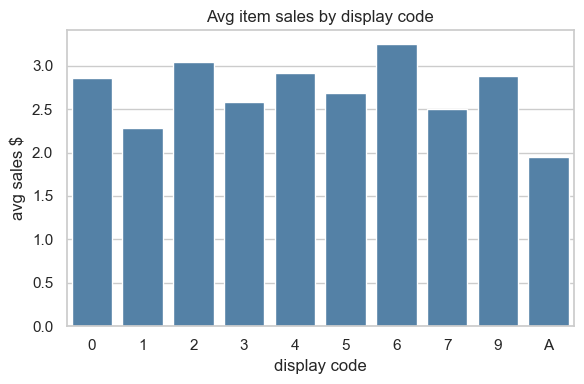

In [14]:
# 7 - Display / mailer promo effect

# avg item-level sales by display code
promo = q(f"""
    SELECT cd.display,
           AVG(bi.sales_value) AS avg_sales
    FROM   basket_item   bi
    JOIN   basket_header bh USING (basket_id)
    JOIN   causal_data   cd
           ON  cd.product_id = bi.product_id
           AND cd.store_id   = bh.store_id
           AND cd.week_no    = bh.week_no
    GROUP  BY cd.display
    ORDER  BY cd.display
""")

plt.figure(figsize=(6,4))
sns.barplot(data=promo,
            x="display", y="avg_sales",
            color="steelblue")
plt.title("Avg item sales by display code")
plt.xlabel("display code")
plt.ylabel("avg sales $")
plt.tight_layout()
plt.show()

       grp      spend
0  control  173570.71
1   target   79975.60


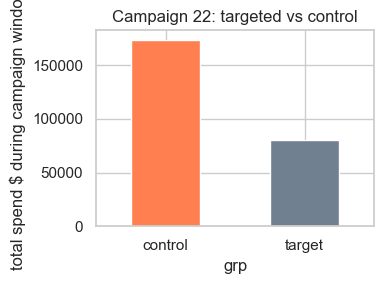

In [15]:
# 8 - Campaign vs non-campaign spend (bar)

# random campaign number
campaign = 22 

# find its day window
start_end = q(f"""
    SELECT start_day, end_day
    FROM   campaign_desc
    WHERE  campaign = :c
""", c=campaign).iloc[0]
start, end = start_end["start_day"], start_end["end_day"]

# list of households that were targeted
# --- build clean Python ints -------------------------------------------------
targets      = q(f"""
    SELECT household_key
    FROM   campaign_table
    WHERE  campaign = :c
""", c=campaign)["household_key"].astype(int).tolist()   # <─ cast here
targets_tuple = tuple(targets) if targets else (-1,)     # guard

start = int(start)      # ensure scalar Python ints
end   = int(end)

spent = q(f"""
    SELECT
      CASE
        WHEN bh.household_key = ANY(:t) THEN 'target'
        ELSE 'control'
      END AS grp,
      SUM(bi.sales_value) AS spend
    FROM   basket_header bh
    JOIN   basket_item  bi USING (basket_id)
    WHERE  bh.day BETWEEN :s AND :e
    GROUP  BY grp
""", t=list(targets_tuple), s=start, e=end)  

print(spent)

plt.figure(figsize=(4,3))
spent.set_index("grp")["spend"].plot(kind="bar", color=["coral","slategray"])
plt.ylabel("total spend $ during campaign window")
plt.title(f"Campaign {campaign}: targeted vs control")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

       grp   hh  avg_spend  avg_trips
0  control  734     314.33       9.45
1   target   42     543.50       9.95


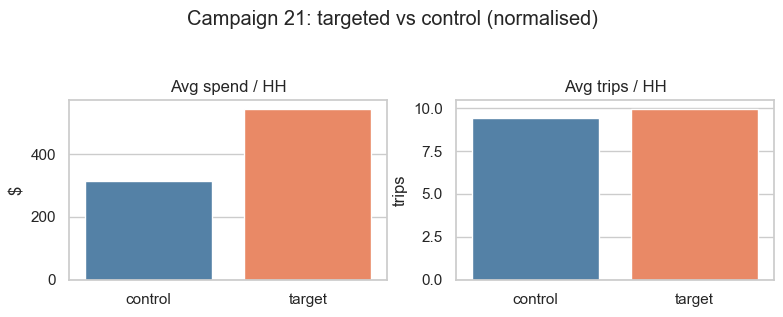

In [16]:
# 9 - One campaign-target vs the regular average
campaign = 21    

# find campaign window (start_day … end_day)
start, end = q(f"""
    SELECT start_day, end_day
    FROM   campaign_desc
    WHERE  campaign = :c
""", c=campaign).iloc[0].astype(int)

# households that were targeted
targets = (q(f"""
    SELECT household_key
    FROM   campaign_table
    WHERE  campaign = :c
""", c=campaign)["household_key"]
           .astype(int)
           .tolist())

targets_list = targets or [-1]          # guard empty list

# per-household spend & trips during the window
hh = q(f"""
    SELECT
      bh.household_key,
      CASE WHEN bh.household_key = ANY(:t) THEN 'target' ELSE 'control' END AS grp,
      SUM(bi.sales_value)          AS spend,
      COUNT(DISTINCT bh.basket_id) AS trips
    FROM   basket_header bh
    JOIN   basket_item  bi USING(basket_id)
    WHERE  bh.day BETWEEN :s AND :e
    GROUP  BY bh.household_key, grp
""", t=targets_list, s=start, e=end)

summary = (hh
           .groupby("grp")
           .agg(hh=('household_key','nunique'),
                avg_spend=('spend','mean'),
                avg_trips=('trips','mean'))
           .round(2)
           .reset_index())

print(summary)

# colour mapping
col = {"control": "steelblue", "target": "coral"}

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.barplot(ax=axes[0], data=summary,
            x="grp", y="avg_spend",
            hue="grp", palette=col, legend=False)
axes[0].set_title("Avg spend / HH")
axes[0].set_ylabel("$"); axes[0].set_xlabel("")

sns.barplot(ax=axes[1], data=summary,
            x="grp", y="avg_trips",
            hue="grp", palette=col, legend=False)
axes[1].set_title("Avg trips / HH")
axes[1].set_ylabel("trips"); axes[1].set_xlabel("")

plt.suptitle(f"Campaign {campaign}: targeted vs control (normalised)", y=1.05)
plt.tight_layout()
plt.show()